Name: plot_skewt.ipynb

Author: Robert M. Frost

NOAA Global Systems Laboratory

Created: 04 July 2023

Purpose: Plot skew-t soundings and hodographs of SRW output

In [147]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
from plotting_functions import read_grib
from metpy.plots import Hodograph, SkewT
from metpy.units import units
import metpy.calc as mpcalc
import numpy as np

Important parameters

In [148]:
# hour of interest
hr = 22
# directory where hrrr grib data are located
dgrib_h = "/scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/"
# directory where rap grib data are located
dgrib_r = "/scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_rapphys/2023041900/postprd/"
# natlev or prslev
nat_prs = "natlev"
# message number for T at isobaric levels in hPa
mn_t = np.arange(14,794.1,20).astype(int)
# message number for specific humidity
mn_q = mn_t + 1
# message number for u wind component
mn_u = mn_t + 2
# message number for v wind component
mn_v = mn_t + 3
# message number for pressure
mn_p = np.arange(2,782.1,20)

# desired latitude and longitude values
des_lat, des_lon = 32.238915, -99.817083

# directory for figure to be output
figdir = "/scratch2/BMC/fv3lam/Robby.Frost/figures/20230419/skewt/"

Read in temperature

In [149]:
# create arrays for temperature
Th = np.empty(mn_t.size)
Tr = np.empty(mn_t.size)
# create arrays for specific humidity
qh = np.empty(mn_t.size)
qr = np.empty(mn_t.size)
# create arrays for pressure
ph = np.empty(mn_t.size)
pr = np.empty(mn_t.size)
# create arrays for u wind
uh = np.empty(mn_t.size)
ur = np.empty(mn_t.size)
# create arrays for v wind
vh = np.empty(mn_t.size)
vr = np.empty(mn_t.size)

# read in output files
grbs_h, T_h, lat, lon, valid_date = read_grib(hr, dgrib_h, nat_prs, int(mn_t[0]))
grbs_r, T_r, lat, lon, valid_date = read_grib(hr, dgrib_r, nat_prs, int(mn_t[0]))

# find index nearest to desired
lat_idx = np.argmin(np.abs(des_lat - lat[:,500]))
lon_idx = np.argmin(np.abs(des_lon - lon[840,:]))

# loop over hybrid levels
for i in range(mn_t.size):
    # read in temperature
    Th_2d = grbs_h[int(mn_t[i])]
    Tr_2d = grbs_r[int(mn_t[i])]
    # store in array
    Th[i] = Th_2d.values[lat_idx, lon_idx]
    Tr[i] = Tr_2d.values[lat_idx, lon_idx]

    # read in specific humidity
    qh_2d = grbs_h[int(mn_q[i])]
    qr_2d = grbs_r[int(mn_q[i])]
    # store in array
    qh[i] = qh_2d.values[lat_idx, lon_idx]
    qr[i] = qr_2d.values[lat_idx, lon_idx]

    # read in pressure
    ph_2d = grbs_h[int(mn_p[i])]
    pr_2d = grbs_r[int(mn_p[i])]
    # store in array
    ph[i] = ph_2d.values[lat_idx, lon_idx]
    pr[i] = pr_2d.values[lat_idx, lon_idx]

    # read in u component
    uh_2d = grbs_h[int(mn_u[i])]
    ur_2d = grbs_r[int(mn_u[i])]
    # store in array
    uh[i] = uh_2d.values[lat_idx,lon_idx]
    ur[i] = ur_2d.values[lat_idx,lon_idx]

    # read in v component
    vh_2d = grbs_h[int(mn_v[i])]
    vr_2d = grbs_r[int(mn_v[i])]
    # store in array
    vh[i] = vh_2d.values[lat_idx,lon_idx]
    vr[i] = vr_2d.values[lat_idx,lon_idx]

    print(f"Finished with hybrid level {i}")


Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in Temperature
Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_rapphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in Temperature
Finished with hybrid level 0
Finished with hybrid level 1
Finished with hybrid level 2
Finished with hybrid level 3
Finished with hybrid level 4
Finished with hybrid level 5
Finished with hybrid level 6
Finished with hybrid level 7
Finished with hybrid level 8
Finished with hybrid level 9
Finished with hybrid level 10
Finished with hybrid level 11
Finished with hybrid level 12
Finished with hybrid level 13
Finished with hybrid level 14
Finished with hybrid level 15
Finished with hybrid level 16
Finished with hybrid level 17
Finished with hybrid level 18
Finished with hybrid level 19
Finished with hybrid level 20
Finished with hybrid le

Unit Conversions

In [150]:
# convert to celsius
Th = Th - 273.15
Tr = Tr - 273.15
# convert to hectopascals
ph = ph / 100
pr = pr / 100

Calculate dew point

In [151]:
# empty arrays for calculated variables
Esh = np.empty(mn_t.size)
Esr = np.empty(mn_t.size)
Eh = np.empty(mn_t.size)
Er = np.empty(mn_t.size)
Tdh = np.empty(mn_t.size)
Tdr = np.empty(mn_t.size)

# calculate saturation vapor pressure for hrrr
Esh = (6.112 * np.exp(17.67 * Th)) / (Th + 243.5)
# calculate saturation vapor pressure for rap
Esr = (6.112 * np.exp(17.67 * Tr)) / (Tr + 243.5)

# calculate vapor pressure for hrrr
Eh = (qh * ph) / (0.622 + 0.378 * qh)
# calculate vapor pressure for rap
Er = (qr * pr) / (0.622 + 0.378 * qr)

# calculate dew point for hrrr
Tdh = (243.5 * np.log(Eh / 6.112)) / (17.67 - np.log(Eh / 6.112))
# calculate dew point for rap
Tdr = (243.5 * np.log(Er / 6.112)) / (17.67 - np.log(Er / 6.112))

Convert temperature to fahrenheit

In [152]:
# temperature
Thf = (Th * 9 / 5) + 32
Trf = (Tr * 9 / 5) + 32
# dew point
Tdhf = (Tdh * 9 / 5) + 32
Tdrf = (Tdr * 9 / 5) + 32

Calculate parcel path

In [153]:
# Assign units to temperature
Thu = units('celsius') * Th
Tru = units('celsius') * Tr
# Assign units to dew point
Tdhu = units('celsius') * Tdh
Tdru = units('celsius') * Tdr
# Assign units to pressure
phu = units('hPa') * ph
pru = units('hPa') * pr

In [154]:
parcel_path = mpcalc.parcel_profile(phu, Thu[0], Tdhu[0])

Plot skew-t

Text(0.5, 1.0, 'HRRR F021, Valid 2023-04-19 21:00:00 at 32.8673, -99.7799')

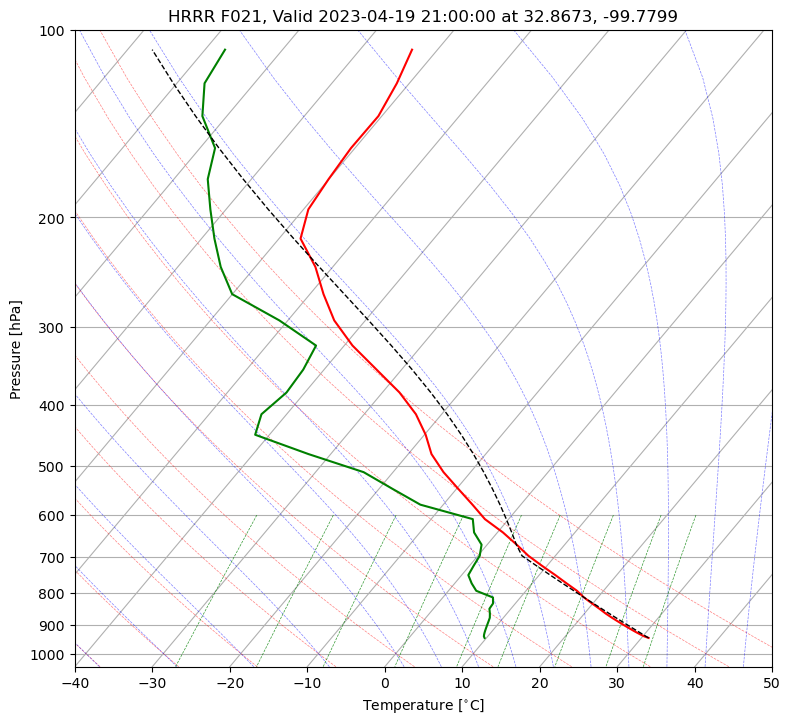

In [155]:
# create figure
fig = plt.figure(figsize=(9,9))

# plot skewt
skew = SkewT(fig, rotation=40)

# plot temp and dew point
skew.plot(ph, Th, 'red')
skew.plot(ph, Tdh, 'green')

# adiabats and mixing ratio
skew.plot_dry_adiabats(lw=0.5)
skew.plot_moist_adiabats(lw=0.5)
skew.plot_mixing_lines(lw=0.5)
# parcel path
skew.plot(ph, parcel_path, color="k", lw=1, ls="--")

# axis titles
skew.ax.set_ylabel("Pressure [hPa]")
skew.ax.set_xlabel("Temperature [$^{\\circ}$C]")

# set figure title
skew.ax.set_title(f"HRRR F0{hr}, Valid {valid_date} at {round(lat[lat_idx,lon_idx],4)}, {round(lon[lon_idx,lon_idx],4)}")